This notebook contains classical problems from Sutton & Barto’s *Reinforcement Learning: An Introduction*.  
The goal is to visualize how different algorithms learn and compare their performance.

---

##  1. Random Walk (TD(0) vs Monte Carlo)

- **Problem:**  
  An agent moves left or right randomly along a line of states (A–E).  
  Reaching the right terminal gives **+1**, while reaching the left terminal gives **0**.  
- **Objective:**  
  Learn the value of the non-terminal states.  
- **Methods:**  
  - **Monte Carlo (MC):** Updates using full returns after an episode ends.  
  - **TD(0):** Uses one-step bootstrapped updates with the next state’s estimate.  
- **Observation:**  
  - TD(0) → lower variance, faster stabilization.  
  - MC → higher variance, but uses complete returns and may be more accurate in the long run.  
- **Plots:** Compare learned values against the true state values.

---

##  2. Cliff Walking (SARSA vs Q-learning)

- **Problem:**  
  On a 4×12 grid, the agent starts in the bottom-left and must reach the bottom-right goal.  
  Stepping into cliff cells (bottom row, columns 1–10) yields **-100** and resets the agent to the start.  
  Each step costs **-1**.  
- **Objective:**  
  Learn a safe and reward-maximizing policy.  
- **Methods:**  
  - **SARSA (on-policy TD control):** Updates using the action actually taken under the current policy.  
  - **Q-learning (off-policy TD control):** Updates assuming the best possible (greedy) action is taken.  
- **Observation:**  
  - SARSA → learns safer, more conservative paths away from the cliff.  
  - Q-learning → pushes toward the optimal path, even if it risks falling off the cliff.  
- **Plots:** Average episodic returns compared across both methods.

---

## 📌 Notes
- Results may vary between runs due to randomness in the environment.  

---


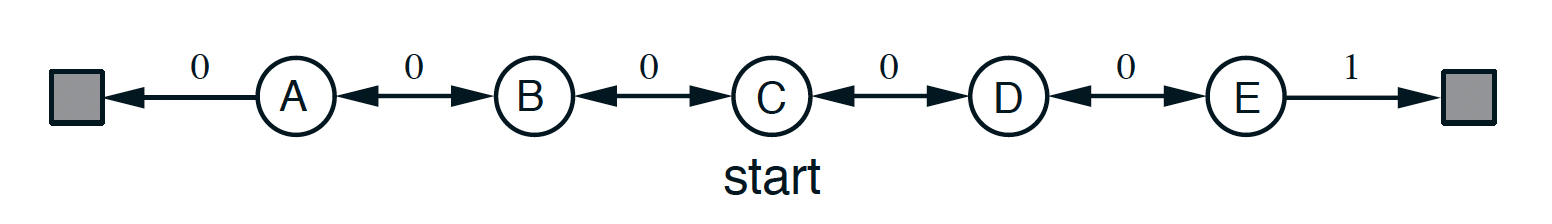

In [1]:
import numpy as np, random
import matplotlib.pyplot as plt
np.random.seed(42)
random.seed(42)

# Define the states: A (0) to E (4), with terminal states at -1 (left) and +1 (right)
num_states = 5
states = np.arange(1, num_states + 1)  # states B to F (mapped to 1-5)
start_state = 3  # C is the center, index 3
terminal_left = 0
terminal_right = num_states + 1

def true_value():
    """True values for states A-E, with 0 and 1 at ends"""
    return np.linspace(1/6, 5/6, num_states)


In [2]:
def generate_episode():
    state = start_state
    episode = []
    while True:
        if state == terminal_left:
            return episode, 0
        if state == terminal_right:
            return episode, 1
        next_state = state + np.random.choice([-1, 1])
        episode.append(state)
        state = next_state


### TD(0) Learning  

In [3]:
def td_0(alpha, episodes=100):
    V = np.zeros(num_states + 2)
    for _ in range(episodes):
        state = start_state
        while state != terminal_left and state != terminal_right:
            next_state = state + np.random.choice([-1, 1])
            reward = 1 if next_state == terminal_right else 0
            V[state] += alpha * (reward + V[next_state] - V[state])
            state = next_state
    return V[1:-1]  # exclude terminal states


### Constant-α Monte Carlo

In [4]:
def mc_constant_alpha(alpha, episodes=100):
    V = np.zeros(num_states + 2)
    for _ in range(episodes):
        episode, reward = generate_episode()
        for state in episode:
            V[state] += alpha * (reward - V[state])
    return V[1:-1]  # exclude terminal states


### Evaluate Error Over Time

In [5]:
def rms_error(V, true_V):
    return np.sqrt(np.mean((V - true_V) ** 2))

alphas = [0.05, 0.1, 0.15]
episodes_list = [10, 20, 50, 100, 200, 500]
true_V = true_value()

td_errors = {alpha: [] for alpha in alphas}
mc_errors = {alpha: [] for alpha in alphas}

for alpha in alphas:
    for episodes in episodes_list:
        td_V = td_0(alpha, episodes)
        mc_V = mc_constant_alpha(alpha, episodes)
        td_errors[alpha].append(rms_error(td_V, true_V))
        mc_errors[alpha].append(rms_error(mc_V, true_V))


### Plot the Results (Estimated Values vs True Values for both methods)

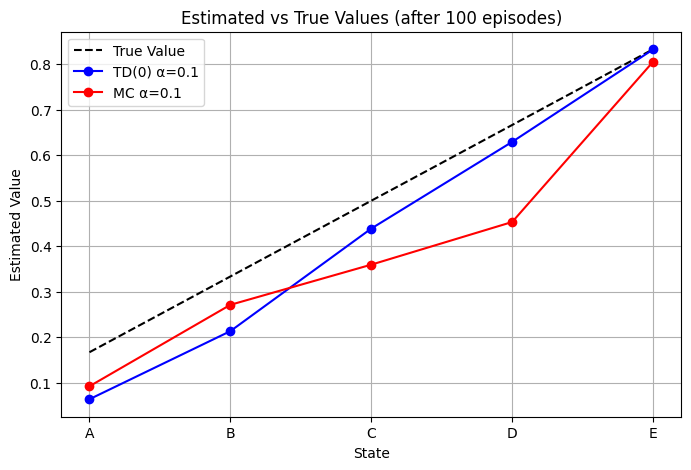

In [6]:
# Choose one alpha and episode count to visualize
alpha = 0.1
episodes = 100

# Estimate values using TD(0) and MC
td_estimates = td_0(alpha=alpha, episodes=episodes)
mc_estimates = mc_constant_alpha(alpha=alpha, episodes=episodes)

# True values
true_V = true_value()

# Labels for states A to E
labels = ['A', 'B', 'C', 'D', 'E']
x = np.arange(len(labels))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, true_V, 'k--', label='True Value')
plt.plot(x, td_estimates, 'bo-', label=f'TD(0) α={alpha}')
plt.plot(x, mc_estimates, 'ro-', label=f'MC α={alpha}')
plt.xticks(x, labels)
plt.xlabel('State')
plt.ylabel('Estimated Value')
plt.title(f'Estimated vs True Values (after {episodes} episodes)')
plt.legend()
plt.grid(True)
plt.show()


### **Cliff Walking Problem Using SARSA**



### 1. Define the Gridworld Environment

In [7]:
class CliffWalkingEnv:
    def __init__(self, rows=4, cols=12):
        self.rows = rows
        self.cols = cols
        self.start = (3, 0)
        self.goal = (3, 11)
        self.reset()

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        r, c = self.state
        if action == 0: r = max(r - 1, 0)       # up
        if action == 1: r = min(r + 1, self.rows - 1)  # down
        if action == 2: c = max(c - 1, 0)       # left
        if action == 3: c = min(c + 1, self.cols - 1)  # right
        next_state = (r, c)

        if r == 3 and 1 <= c <= 10:  # fell off the cliff
            return self.start, -100, True
        elif next_state == self.goal:
            return next_state, 0, True
        else:
            self.state = next_state
            return next_state, -1, False

    def get_state_space(self):
        return [(r, c) for r in range(self.rows) for c in range(self.cols)]

    def get_action_space(self):
        return [0, 1, 2, 3]  # up, down, left, right


### 2. E-Greedy Selection Action

In [8]:
def epsilon_greedy(Q, state, actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    q_vals = Q[state]
    max_q = np.max(q_vals)
    best_actions = [a for a in actions if q_vals[a] == max_q]
    return np.random.choice(best_actions)


### 3. SARSA Algorithm

In [11]:
from collections import defaultdict

def sarsa(env, episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(4))
    rewards = []

    for ep in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, env.get_action_space(), epsilon)
        total_reward = 0
        done = False

        while not done:
            next_state, reward, done = env.step(action)
            next_action = epsilon_greedy(Q, next_state, env.get_action_space(), epsilon)

            # SARSA update
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

            state, action = next_state, next_action
            total_reward += reward

        rewards.append(total_reward)

    return Q, rewards


### 4. Train SARSA

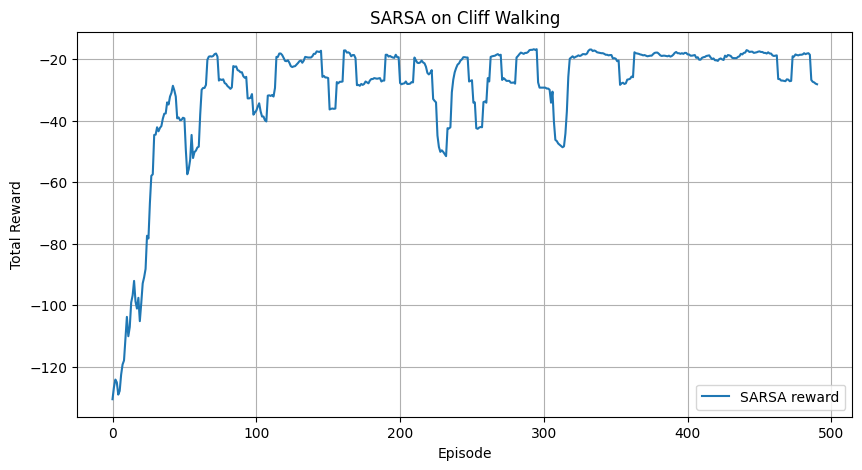

In [12]:
env = CliffWalkingEnv()
Q_sarsa, rewards_sarsa = sarsa(env, episodes=500)

# Plot total rewards per episode
def smooth(x, window=10):
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smooth(rewards_sarsa), label='SARSA reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('SARSA on Cliff Walking')
plt.grid(True)
plt.legend()
plt.show()


### 5. Visualization of the path followed by our Reinforcement Learning Agent

In [13]:
def visualize_path(Q, env):
    grid = np.full((env.rows, env.cols), '.', dtype=str)
    state = env.start
    grid[env.goal] = 'G'
    grid[env.start] = 'S'

    while state != env.goal:
        action = np.argmax(Q[state])
        r, c = state

        if action == 0: r = max(r - 1, 0)
        elif action == 1: r = min(r + 1, env.rows - 1)
        elif action == 2: c = max(c - 1, 0)
        elif action == 3: c = min(c + 1, env.cols - 1)

        next_state = (r, c)
        if next_state == env.start or grid[next_state] == 'S':
            break

        if grid[next_state] == '.':
            grid[next_state] = '*'
        state = next_state

    for r in range(env.rows):
        print(' '.join(grid[r]))

visualize_path(Q_sarsa, env)


. * * . * * * * * * * *
* * * * * . . . . . . *
* . . . . . . . . . . *
S . . . . . . . . . . G


## **Cliff Walking Problem using Q-Learning**

### 1. Define Q Learning

In [14]:
def q_learning(env, episodes=500, alpha=0.5, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(4))  # 4 actions
    rewards = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy(Q, state, env.get_action_space(), epsilon)
            next_state, reward, done = env.step(action)
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
    return Q, rewards

### 2 . Train and Visualize

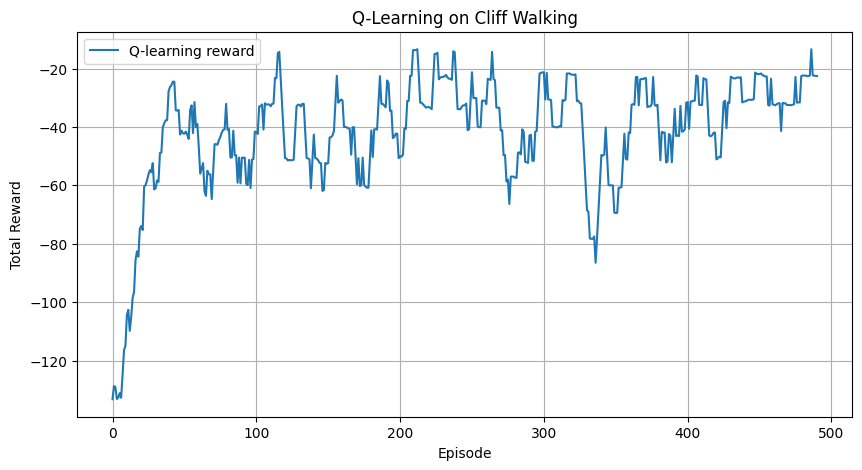

In [15]:
env = CliffWalkingEnv()
Q, rewards = q_learning(env, episodes=500)

# Smooth plot
def smooth(x, window=10):
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smooth(rewards), label='Q-learning reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning on Cliff Walking')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
visualize_path(Q, env)

. . . . . . . . . . . .
. . . . . . . . . . . .
* * * * * * * * * * * *
S . . . . . . . . . . G
